## Group Assignment

In [1]:
import os
import numpy as np
import random
import math
import librosa.display
import matplotlib
from  matplotlib import pyplot as plt
import librosa
from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
import copy
%matplotlib inline

In [2]:
# All the functions
eps = np.finfo(float).eps

# Default Values
N_FFT = 2048
FRAME_LEN = 2048
HOP_LEN = 512
WIN_LEN = 2048
WINDOW = 'hann'
sr = 22050

def spectral_flux(X, f_s):
    """
    adapted from https://www.audiocontentanalysis.org/code/audio-features/spectral-flux-2/
    computes the spectral flux from the magnitude spectrum

      Args:
        X: spectrogram (dimension FFTLength X Observations)
        f_s: sample rate of audio data

      Returns:
        vsf spectral flux
    """
    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)
    # difference spectrum (set first diff to zero)
    X = np.c_[X[:, 0], X]
    afDeltaX = np.diff(X, 1, axis=1)
    # flux
    vsf = np.sqrt((afDeltaX**2).sum(axis=0)) / X.shape[0]
    return np.squeeze(vsf) if isSpectrum else vsf

def inst_freq_descriptors(y, sr, n_fft=N_FFT, hop_length=HOP_LEN, window=WINDOW, win_length=None):
    # Spectral Descriptors
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
    spec_flux = spectral_flux(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length), sr)
    spec_flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)

    return spec_centroid, spec_bandwidth, spec_flux, spec_flatness

def inst_time_descriptors(y, sr, frame_length=FRAME_LEN, hop_length=HOP_LEN):
    # Instantaneous Time Descriptors
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hop_length)

    return rms, zcr

def plot_time_descriptors(y, Fs):
    fig, ax = plt.subplots(1)
    img = librosa.display.waveplot(y, x_axis='time', ax=ax)
    rms, zcr = inst_time_descriptors(y, Fs)
    times = librosa.times_like(rms)
    ax.plot(times, rms.T, label='RMS', color='b')
    ax.plot(times, zcr.T, label='ZCR', color='r')
    ax.legend(loc='upper right')
    return True

def plot_frequency_descriptors(y, Fs):
    # Get Discrete FT
    D = librosa.stft(y)  # STFT of y
    # Get Spectrogram in dB
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(2, sharex=True)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax[1])
    spec_centroid, spec_bw, spec_flux, spec_flat = inst_freq_descriptors(y, Fs)
    times = librosa.times_like(spec_centroid)

    ax[1].plot(times, spec_centroid.T, label='spec_centroid', color='w')
    ax[1].plot(times, spec_bw.T, label='spec_bw', color='b')
    ax[1].fill_between(times, spec_centroid[0] - spec_bw[0], spec_centroid[0] + spec_bw[0],
                       alpha=0.5, label='Centroid +- bandwidth')
    ax[1].legend(loc='upper right')
    # Plot in a different axis because it is in a different order of magnitude
    # and can't be seen in the other axis
    ax[0].plot(times, spec_flux, label='spec_flux', color='r')
    ax[0].plot(times, spec_flat.T, label='spec_flat', color='g')
    ax[0].legend(loc='upper right')
    return True


In [5]:
def get_all_wav_files_on_data():

    wav_path = []
    init_col_mark = [[], []]
    cursor_types = ['bo', 'gv', 'r^' ,'c<', 'm>', 'y1', 'b2', 'g3', 'r4', 'c8', 'ms', 'yp', 'bP', 'g*', 'rh', 'cH']
    #cursor_types = ['bo', 'r^']
    aux = ""
    
    i = 1
    
    for root, dirs, files in os.walk('.\data'):
        for name in files:
            if name.endswith((".wav")):
                wav_path.append(os.path.join('.', 'audio/input',name))
                
                if name.find(aux) != -1:
                    i=i-1
                
                aux = name[0:3]    
                
                init_col_mark[0].append(name[0:3])
                init_col_mark[1].append(cursor_types[i])
                
                #if aux == "gui" or aux == "hrp":
                #    init_col_mark[1].append(cursor_types[1])
                #else:
                #    init_col_mark[1].append(cursor_types[0])
                i=i+1
    
    return wav_path, init_col_mark

def global_time_descriptors(y, sr):
    # Global Time Descriptors
    tc = temporal_centroid(y, sr)
    lat = simple_log_attack_time(y, sr)
    # Normalized descriptors (normalized by duration of sound)
    ntc = tc/librosa.get_duration(y=y, sr=sr)
    nlat = np.exp(lat)/librosa.get_duration(y=y, sr=sr)
    return tc, lat, ntc, nlat


def simple_log_attack_time(x, f_s):
    """
    computes the log-attack time from the waveform (time from 20% to 90%)
      Args:
        x: waveform 
        f_s: sample rate of audio data

      Returns:
        lat (in secs)
    """
    def find_nearest_arg(array, value):
        array = np.asarray(np.squeeze(array))
        idx = (np.abs(array - value)).argmin()
        return idx

    rms = librosa.feature.rms(y=x, frame_length=FRAME_LEN, hop_length=HOP_LEN)
    e20_pos = find_nearest_arg(rms, 0.2*np.max(rms))
    e90_pos = find_nearest_arg(rms, 0.9*np.max(rms))
    e20_time = e20_pos * HOP_LEN/sr
    e90_time = e90_pos * HOP_LEN/sr
    if e20_time > e90_time:
        e20_time = 0
    lat = np.log(e90_time - e20_time + eps)
    return lat

def effective_duration(y, Fs):
    threshold = 0.4*np.max(y)
    indices = np.where(np.abs(y) > threshold)[0]
    p1 = indices[0]
    p2 = indices[len(indices)-1]
    ed = (p2 - p1) / Fs
    return ed / librosa.get_duration(y=y, sr=Fs)


def temporal_centroid(x, f_s):
    """
    adapted from https://www.audiocontentanalysis.org/code/audio-features/spectral-centroid-2/
    computes the temporal centroid from the waveform
      Args:
        x: waveform 
        f_s: sample rate of audio data

      Returns:
        vtc temporal centroid (in secs)
    """
    x = np.power(x,2)
    norm = x.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1
    vtc = np.dot(np.arange(0, x.shape[0]), x) / norm
    # convert from index to sec
    vtc = vtc / f_s
    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vtc = np.squeeze(vtc)
    return vtc

def calc_statistical_features(arr):
    result = np.zeros(5)
    result[0] = np.mean(arr).real
    result[1] = np.var(arr)
    result[2] = np.median(arr).real
    result[3] = np.min(arr).real
    result[4] = np.max(arr).real
    result = np.nan_to_num(result)
    return result

def mean_descriptors(path):
    x, Fs = librosa.load(path)
    spec_centroid, spec_bw, spec_flux, spec_flat = inst_freq_descriptors(x, Fs)
    zcr = librosa.feature.zero_crossing_rate(y=x)
    tc, lat, ntc, nlat = global_time_descriptors(x, Fs)
    ned = effective_duration(x, Fs)
    
    scentroid_stat = calc_statistical_features(spec_centroid)
    sspread_stat = calc_statistical_features(spec_bw)
    sflux_stat = calc_statistical_features(spec_flux)
    sflat_stat = calc_statistical_features(spec_flat)
    zcr_stat = calc_statistical_features(zcr)
   
    return scentroid_stat[0], sspread_stat[0], sflux_stat[0], sflat_stat[0], zcr_stat[0], ntc, nlat, ned

def create_graph(path_array, nam_col_mark):
    
    i=0
    inst = "nenhum"
    hits = 0
    fig = plt.figure(figsize=(16, 9))

    gs = matplotlib.gridspec.GridSpec(ncols=2, nrows=2)
    ax1, ax2, ax3, ax4 = [plt.subplot(gs[i]) for i in range(4)]
    
    for path in path_array:
        sc, ss, sfu, sfa, zcr, ntc, nlat, ned = mean_descriptors(path)
        
            
        if ntc > 3.29 * nlat-0.69:
            inst = "cbs"
        
        if ntc > 2.8 * nlat-0.7:
            inst = "trp"
        
        if ntc <  3.39 * nlat - 0.95:
            inst = "vln"
            
        if ntc < 2.5 * nlat - 0.4:
            inst = "trb"
            
        if ntc < -0.714 * nlat + 0.55:
            inst = "vcl"
        
        if ntc > nlat * 3.03-0.91:
            inst = "acc"
        
        if ntc > 3.636 * nlat-0.4:
            inst = "gui"
        
        if ntc < -1.286 * nlat + 0.18:
            inst = "hrp"
        
        if inst == nam_col_mark[0][i]:
            hits += 1
        
        ax1.plot(sfu, ss, label = nam_col_mark[0][i], color = (nam_col_mark[1][i])[0], marker=(nam_col_mark[1][i])[1])
        ax2.plot(sfu, sfa, label = nam_col_mark[0][i], color = (nam_col_mark[1][i])[0], marker=(nam_col_mark[1][i])[1])
        ax3.plot(sc, zcr, label = nam_col_mark[0][i], color = (nam_col_mark[1][i])[0], marker=(nam_col_mark[1][i])[1])
        ax4.plot(ntc, nlat, label = nam_col_mark[0][i], color = (nam_col_mark[1][i])[0], marker=(nam_col_mark[1][i])[1])
        
        print("Effective duration da amostra", nam_col_mark[0][i], i+1, "=", ned, sep=" ")
        if ned > 0.2:
            print("Sustentado")
        else:
            print("Não sustentado")
        i+=1
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
        
    ax1.set_xlabel('Média do Spectral Flux')
    ax1.set_ylabel('Média do Spectral Spread')
    ax1.set_title('Spectral Flux / Spectral Spread')
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    ax2.set_xlabel('Média do Spectral Flux')
    ax2.set_ylabel('Média do Spectral Flatness')
    ax2.set_title('Spectral Flux / Spectral Flatness')
    ax2.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    ax3.set_xlabel('Média do Spectral Centroid')
    ax3.set_ylabel('Média do Zero Crossing Rate')
    ax3.set_title('Spectral Centroid / Zero Crossing Rate')
    ax3.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    ax4.set_xlabel('Log Attack Time Normalizado')
    ax4.set_ylabel('Temporal Centroid Normalizado')
    ax4.set_title('LATN / TCN')
    ax4.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    print("Taxa de sucesso nos instrumentos acertados", "=", hits/i, sep=" ")
    
    return True

ZeroDivisionError: division by zero

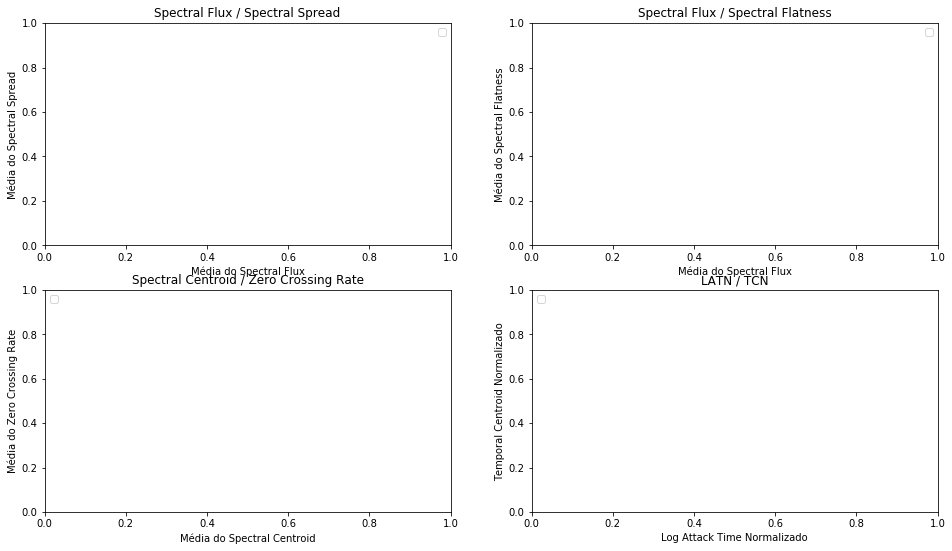

In [6]:
paths, nam_col_mark = get_all_wav_files_on_data()

create_graph(paths, nam_col_mark)